In [1]:
pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import kagglehub
dataset = kagglehub.dataset_download('murtozalikhon/brain-tumor-multimodal-image-ct-and-mri')

import os
print("Path to dataset files:", dataset)

import shutil

source_path = '/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1'

target_path = './dataset'

shutil.copytree(source_path, target_path, dirs_exist_ok=True)

!ls dataset


100%|██████████| 361M/361M [00:05<00:00, 68.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1
Dataset


In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

MRI = datasets.ImageFolder(root='/content/dataset/Dataset/Brain Tumor MRI images', transform=transform)

MRI_dataloader = DataLoader(MRI, batch_size=32, shuffle=True)
MRI_train_size = int(0.8 * len(MRI))
MRI_test_size = len(MRI) - MRI_train_size

MRI_train_dataset, MRI_test_dataset = random_split(MRI, [MRI_train_size, MRI_test_size])

MRI_train_loader = DataLoader(MRI_train_dataset, batch_size=32, shuffle=True)
MRI_test_loader = DataLoader(MRI_test_dataset, batch_size=32, shuffle=True)

print("MRI Training set size:", len(MRI_train_dataset))
print("MRI Testing set size:", len(MRI_test_dataset))

MRI Training set size: 4000
MRI Testing set size: 1000


In [8]:
print("MRI Classes:", MRI.classes)

MRI Classes: ['Healthy', 'Tumor']


In [9]:
def show_MRI_batch(dataloader, title="Batch of CT Images"):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title)

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(MRI.classes[labels[i]])
            ax.axis('off')
    plt.show()

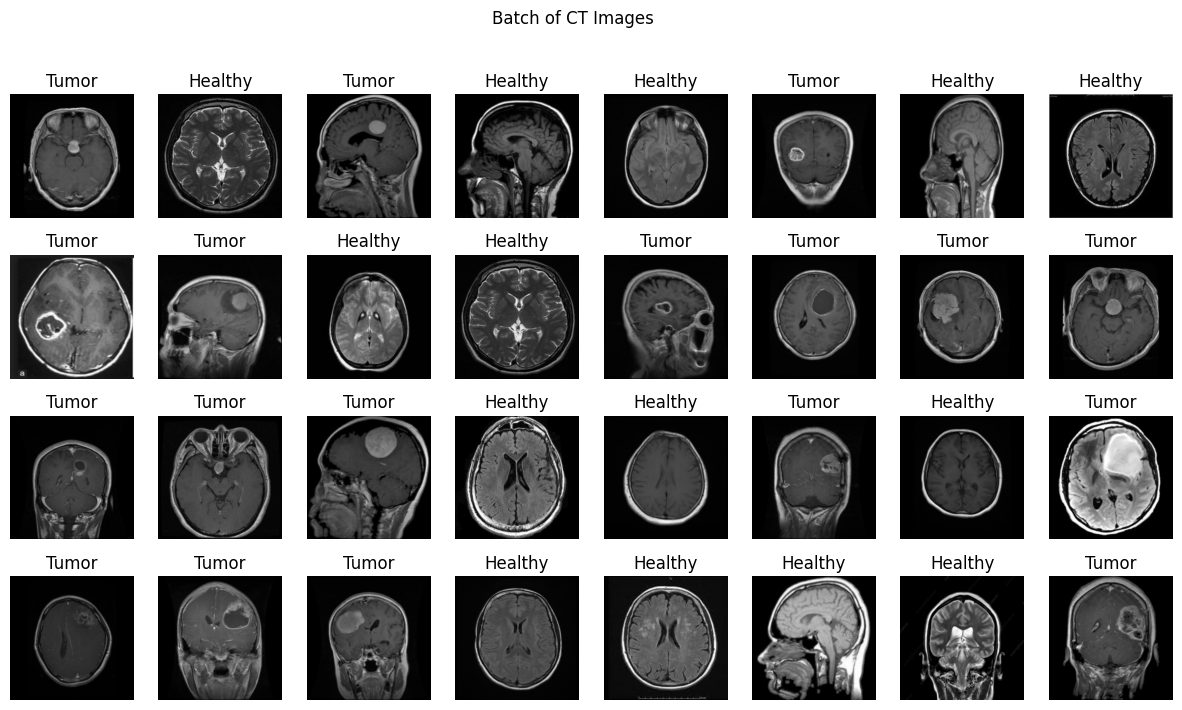

In [10]:
show_MRI_batch(MRI_train_loader)

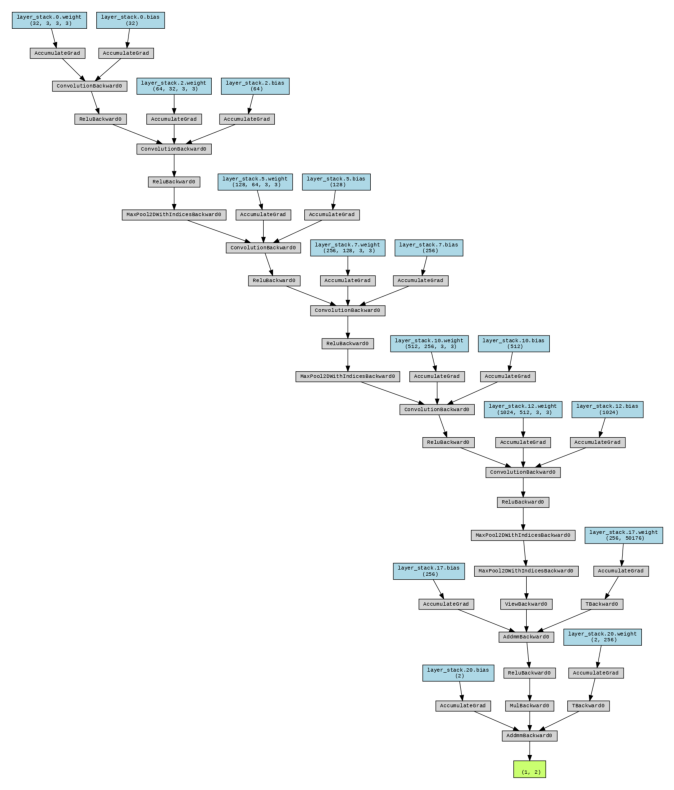

In [11]:
import torch.nn as nn
import torch
from torchviz import make_dot
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import io

class MRIModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),

            nn.MaxPool2d(4, 4),

            nn.Flatten(),

            nn.Linear(7 * 7 * 1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

mri_model = MRIModel(in_channels=3, num_classes=2)
dummy_input = torch.randn(1, 3, 224, 224)
output = mri_model(dummy_input)

dot = make_dot(output, params=dict(mri_model.named_parameters()))
graph_img = dot.pipe(format="png")
image = Image.open(io.BytesIO(graph_img))

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [12]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(mri_model.parameters(),lr=0.001)
mri_model=mri_model.to(device)

In [13]:
from tqdm import tqdm

num_epochs = 10

mri_all_labels = []
mri_all_predictions = []

for epoch in range(num_epochs):
    mri_model.train()
    running_loss = 0.0
    for images, labels in tqdm(MRI_train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mri_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    mri_model.eval()
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in tqdm(MRI_test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = mri_model(images)
            _, predicted = torch.max(outputs, 1)

            mri_all_labels.extend(labels.cpu().numpy())
            mri_all_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(MRI_train_loader):.4f},Accuracy of the model on the validation set: {100 * correct / total:.2f}")

100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Epoch [1/10], Loss: 0.6539,Accuracy of the model on the validation set: 78.60


100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Epoch [2/10], Loss: 0.4256,Accuracy of the model on the validation set: 86.50


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Epoch [3/10], Loss: 0.3104,Accuracy of the model on the validation set: 90.90


100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


Epoch [4/10], Loss: 0.2741,Accuracy of the model on the validation set: 89.20


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Epoch [5/10], Loss: 0.2262,Accuracy of the model on the validation set: 91.30


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Epoch [6/10], Loss: 0.1907,Accuracy of the model on the validation set: 94.00


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Epoch [7/10], Loss: 0.1681,Accuracy of the model on the validation set: 95.40


100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch [8/10], Loss: 0.1423,Accuracy of the model on the validation set: 94.00


100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Epoch [9/10], Loss: 0.1475,Accuracy of the model on the validation set: 95.10


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]

Epoch [10/10], Loss: 0.1082,Accuracy of the model on the validation set: 96.00


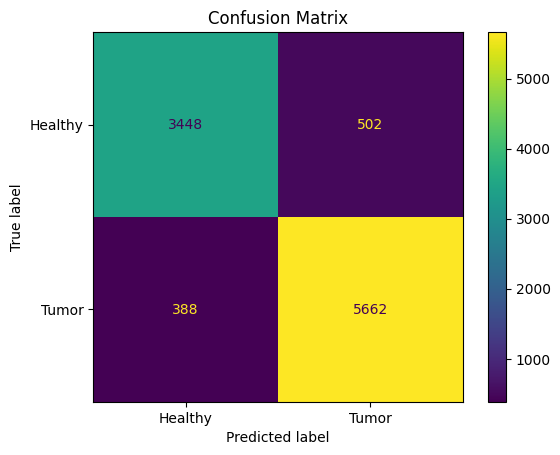

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(mri_all_labels, mri_all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [15]:
torch.save(mri_model, 'mri_model.pth')
mri_saved = torch.load('mri_model.pth')
mri_saved = mri_saved.to(device)

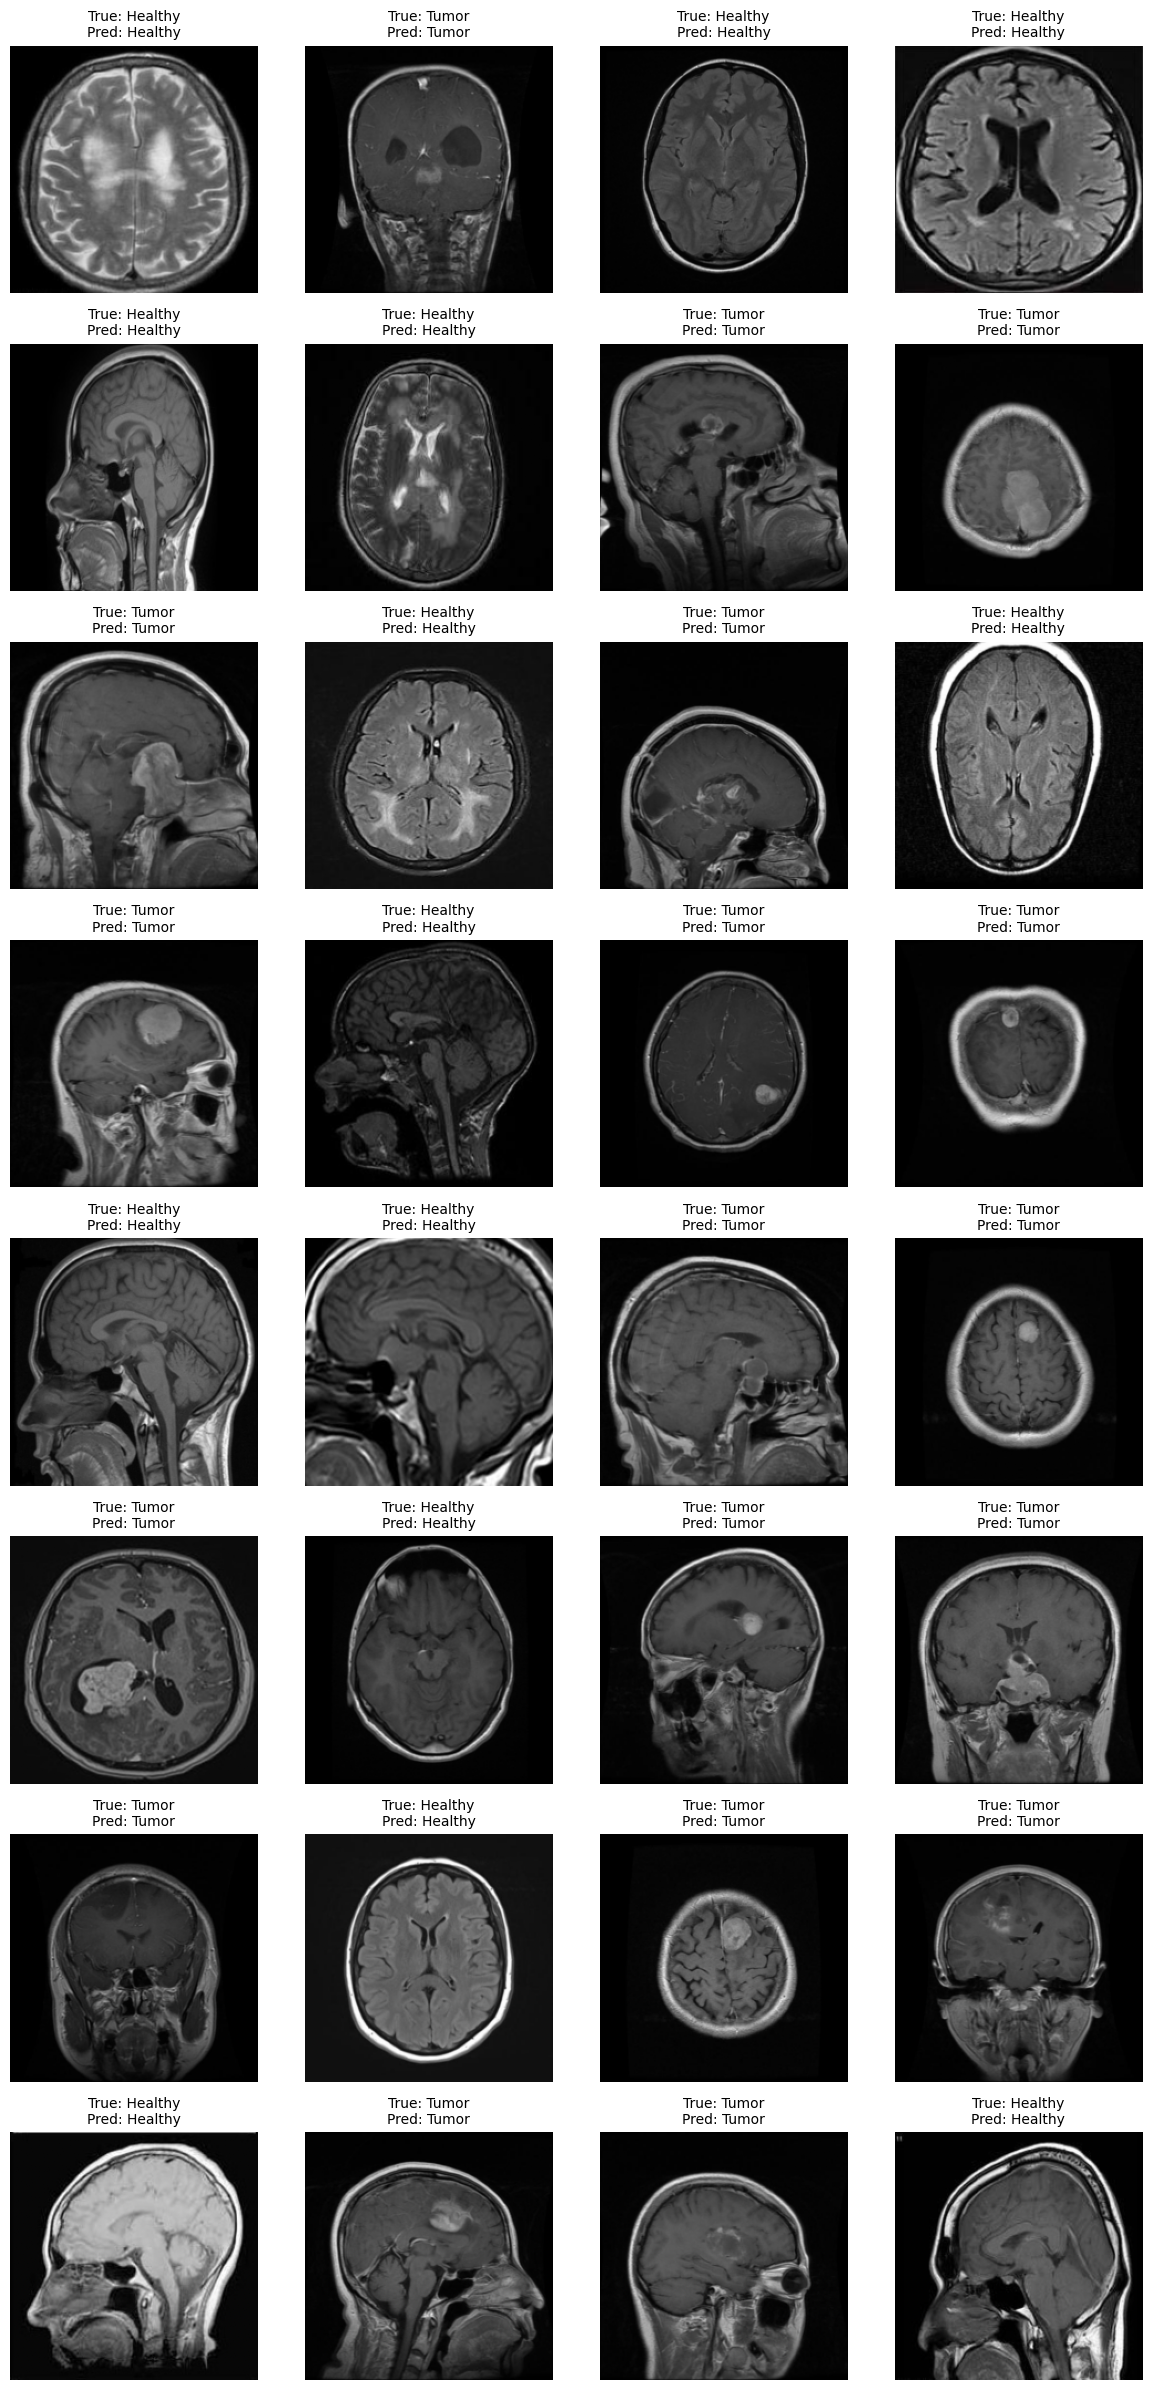

In [16]:
mri_images, mri_labels = next(iter(MRI_test_loader))

mri_images, mri_labels = mri_images.to(device), mri_labels.to(device)

mri_saved.eval()

logits = mri_saved(mri_images)
_, predicted_indices = torch.max(logits, 1)

true_labels = [MRI.classes[label.item()] for label in mri_labels]
predicted_labels = [MRI.classes[pred.item()] for pred in predicted_indices]

batch_size = len(mri_images)
cols = 4
rows = (batch_size + cols - 1) // cols

plt.figure(figsize=(12, rows * 3))

for idx in range(batch_size):
    plt.subplot(rows, cols, idx + 1)
    img = mri_images[idx].cpu().permute(1, 2, 0).numpy()
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()